In [1]:
import sksurv as sks
import sksurv.preprocessing
import sksurv.metrics
import sksurv.datasets
import sksurv.linear_model
import sksurv.ensemble

from pathlib import Path
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy as np
import sklearn as skl
import scipy.stats as sp

import pymc as pm
import pymc_bart as pmb
import pandas as pd

import importlib
import mlflow as ml
import simsurv_func as ssf
import subprocess
import lifelines
import pytensor.tensor as tt
import subprocess

In [151]:
importlib.reload(ssf)

<module 'simsurv_func' from '/home/twj8/pymc_bart/eval_5_cc/simsurv_func.py'>

# Data Generator

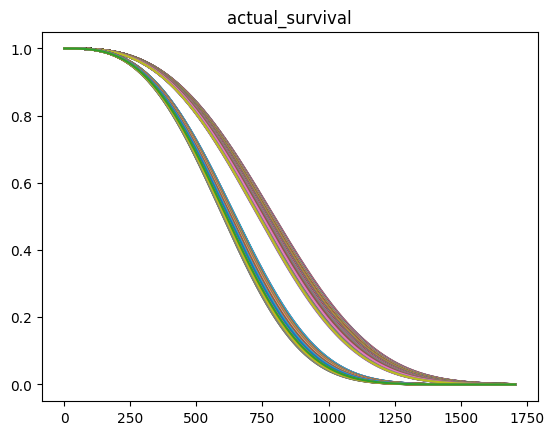

cens_calc: 0.0     
t_mean: 737.94     
t_max: 1706.0


In [16]:
OUTPUTS = "outputs"
ALPHA = 3
VAR_CLASS = [2,2,3,4]
VAR_PROB = [0.2, 0.5, 0.5, 0.2]
LAMBDA = "np.exp(-6.8 + .2*x_mat[:,0] + 0.01*(x_mat[:,1] + x_mat[:,2] + x_mat[:,3]))"
N = 2000
# T = 30
X_VARS = 4
CENS_SCALE = 5# 40
CENS_IND = False

sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = ssf.sim_surv2(
                N=N, 
                x_vars=X_VARS,
                VAR_CLASS= VAR_CLASS,
                VAR_PROB = VAR_PROB,
                a = ALPHA,
                lambda_f = LAMBDA,
                cens_scale=CENS_SCALE,
                cens_ind = CENS_IND,
                err_ind = False)


# Get information of X vars
x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
# calculate censored components
event_calc, cens_calc = ssf.get_status_perc(status) 
# Get the t mean and max
t_mean, t_max = ssf.get_event_time_metric(t_event)
# Get the training matrix
train = ssf.get_train_matrix(x_mat, t_event, status)

# plots moved to kpm by group
title = "actual_survival"
ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True, dir=OUTPUTS)

print(f"cens_calc: {cens_calc} \
    \nt_mean: {t_mean} \
    \nt_max: {t_max}")

# Move average hazard per group below
# get unique x_mat
# x_unique = np.unique(x_mat, return_index=True, axis=0)
# sv_unique = sv_mat[x_unique[1],:]
# hz_unique = np.round(hz_mat[x_unique[1],:],5) 

# HR_unique = hz_unique[1]/hz_unique[0]
# # HR_times = np.arange(0,T,np.floor(T/4), dtype="int")
# HR_times = np.array((np.ceil(T.shape[0]/4) * np.array([1,2,3])), dtype="int")
# print(f"hazard rate 1 {hz_unique[1][HR_times]}")
# print(f"hazard rate 0 {hz_unique[0][HR_times]}")
# print(f"HR t-series = {HR_unique[HR_times]}")

## KPM

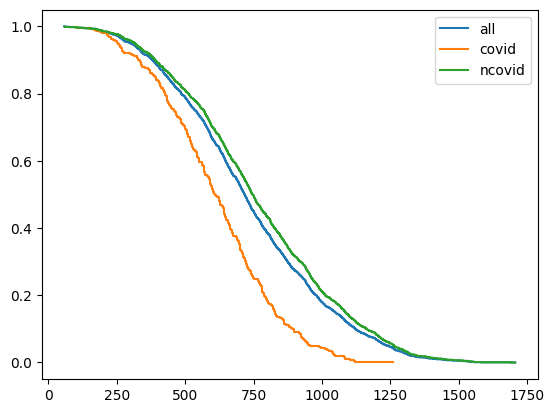

In [17]:
cov_mask = (x_mat[:,0]==1)
y_sk = ssf.get_y_sklearn(status, t_event)

kpm_all = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"], y_sk["Survival_in_days"])
kpm_cov = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][cov_mask], y_sk["Survival_in_days"][cov_mask])
kpm_ncov = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][~cov_mask], y_sk["Survival_in_days"][~cov_mask])
plt.step(kpm_all[0], kpm_all[1], label="all")
plt.step(kpm_cov[0], kpm_cov[1], label="covid")
plt.step(kpm_ncov[0], kpm_ncov[1], label="ncovid")
plt.legend()

# get separate kpm curves
# kpm_cov = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][x_mat[:,0]==1], y_sk["Survival_in_days"][x_mat[:,0]==1])
# kpm_ncov = sks.nonparametric.kaplan_meier_estimator(y_sk["Status"][x_mat[:,0]==0], y_sk["Survival_in_days"][x_mat[:,0]==0])
# kpm_cov = (np.hstack([[0,1],kpm_cov[0]]), np.hstack([[1,1], kpm_cov[1]]))
# kpm_ncov = (np.hstack([[0,1,2,3,4],kpm_ncov[0]]), np.hstack([[1,1,1,1,1], kpm_ncov[1]]))

## HR

In [18]:
# hazard ratio
hz_exp = np.unique(np.round(np.mean(hz_mat[cov_mask],0)/np.mean(hz_mat[~cov_mask],0),3))
print(f"HR expected: {hz_exp[0]}")

HR expected: 1.821


/tmp/ipykernel_331/631933953.py:2: RuntimeWarning: invalid value encountered in divide
  hz_exp = np.unique(np.round(np.mean(hz_mat[cov_mask],0)/np.mean(hz_mat[~cov_mask],0),3))


# Transform to 180 day

In [19]:
# set the eos censoring
TT_ADJ = 410
TT_SCALE = 60
tt_180 = t_event.copy()
y_stat = t_event.copy()
tt_180[tt_180 >= TT_ADJ] = TT_ADJ
tt_180_sc6 = np.ceil(tt_180/TT_SCALE)

y_stat[tt_180 >= TT_ADJ] = 0
y_stat[tt_180 < TT_ADJ] = 1

# print(tt_180)
# print(tt_180_sc6)
# print(y_stat)


In [20]:
print(f"{TT_ADJ} day cases")
print(f"covid events {y_stat[cov_mask].sum()}")
print(f"covid count {y_stat[cov_mask].shape[0]}")
print(f"ncov events {y_stat[~cov_mask].sum()}")
print(f"ncov count {y_stat[~cov_mask].shape[0]}")

410 day cases
covid events 67.0
covid count 384
ncov events 189.0
ncov count 1616


## Data Prep

In [21]:
# KPM for the time adjusted

# y_sk = ssf.get_y_sklearn(status, t_event)
y_sk180 = ssf.get_y_sklearn(y_stat, tt_180_sc6)
x_sk = train.iloc[:,2:]


# tranform data long-form
b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(x_sk, y_sk180)
# b_te_t, b_te_x = surv_pre_test(x_sk, y_sk)
# b_te_x = ssf.get_bart_test(x_out, np.unique(b_tr_t))
b_te_x = ssf.get_bart_test(x_sk, np.unique(b_tr_t))
off = sp.norm.ppf(np.mean(b_tr_delta))

## KPM of tranformed

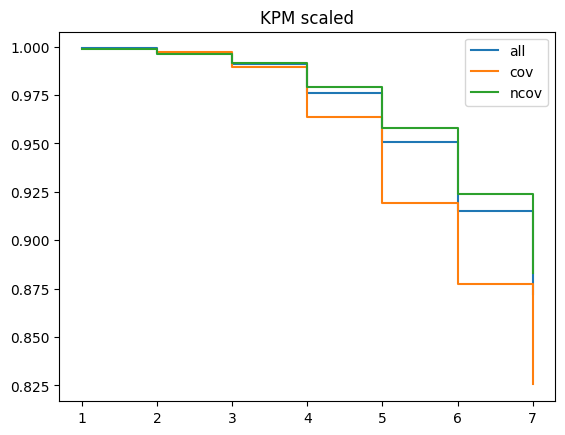

In [24]:
kpm_adj = sks.nonparametric.kaplan_meier_estimator(y_sk180["Status"], y_sk180["Survival_in_days"])
kpm_cadj = sks.nonparametric.kaplan_meier_estimator(y_sk180["Status"][cov_mask], y_sk180["Survival_in_days"][cov_mask])
kpm_ncadj = sks.nonparametric.kaplan_meier_estimator(y_sk180["Status"][~cov_mask], y_sk180["Survival_in_days"][~cov_mask])

plt.step(kpm_adj[0], kpm_adj[1], label="all", where="post")
plt.step(kpm_cadj[0], kpm_cadj[1], label="cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], label="ncov", where="post")
plt.title("KPM scaled")
plt.legend()
# plt.xlim(0,8)

# BART

In [25]:
# BART
M = 200 # number of trees
DRAWS = 100
TUNE = 100
CORES = 6
SPLIT_RULES = [
    pmb.ContinuousSplitRule(),
    pmb.OneHotSplitRule(),
    pmb.OneHotSplitRule(),
    pmb.OneHotSplitRule(),
    pmb.OneHotSplitRule()
]

with pm.Model() as bart:    
    x_data = pm.MutableData("x", b_tr_x)
    f = pmb.BART("f", X=x_data, Y=b_tr_delta, m=M, split_rules = SPLIT_RULES)
    z = pm.Deterministic("z", f + off)
    mu = pm.Deterministic("mu", pm.math.invprobit(z))
    y_pred = pm.Bernoulli("y_pred", p=mu, observed=b_tr_delta, shape=x_data.shape[0])
    bdata = pm.sample(random_seed=2, draws=DRAWS, tune =TUNE, cores=CORES)

with bart:
    pm.set_data({"x":pd.DataFrame(b_te_x)}, coords= {"obs":np.arange(0,b_te_x.shape[0],1)})
    pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])



Only 100 samples in chain.
Multiprocess sampling (6 chains in 6 jobs)
PGBART: [f]


Sampling 6 chains for 100 tune and 100 draw iterations (600 + 600 draws total) took 226 seconds.
/home/twj8/.local/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [f, y_pred]


In [26]:
pp

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [35]:
# fill times
t_min = np.unique(b_tr_t).min()
t_fill = np.arange(t_min)
val_fill = np.ones(t_fill.shape)

array([1.])

In [36]:
# transform to survival
bart_sv_fx = ssf.get_sv_fx(pp, x_sk)
sv_cov = np.mean(bart_sv_fx[cov_mask],0)
sv_ncov = np.mean(bart_sv_fx[~cov_mask],0)
sv_cov = np.hstack([val_fill, sv_cov])
sv_ncov = np.hstack([val_fill, sv_ncov])
bart_sv_val = [sv_ncov, sv_cov]

bart_sv_t = np.unique(b_tr_t)
bart_sv_t = np.hstack([t_fill, bart_sv_t])

## Posterior Predictive Plot

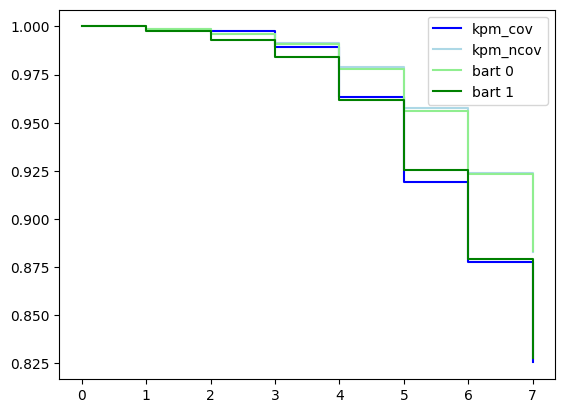

In [38]:
plt.step(kpm_cadj[0], kpm_cadj[1], color="blue", label="kpm_cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], color = "lightblue", label = "kpm_ncov", where="post")

plt.step(bart_sv_t, bart_sv_val[0], color = "lightgreen", label="bart 0", where="post")
plt.step(bart_sv_t, bart_sv_val[1], color = "green", label="bart 1", where="post")
plt.legend()

Plot displays the posterior predictive of the training dataset

## PDP 

In [39]:
# get the pdp setup
x_sk2 = np.vstack([np.array(x_sk),np.array(x_sk)])
x_sk2[:,0] = np.repeat([0,1], x_sk.shape[0])

b_te_x2= ssf.get_bart_test(x_sk2, np.unique(b_tr_t))

In [40]:
with bart:
    pm.set_data({"x":pd.DataFrame(b_te_x2)}, coords= {"obs":np.arange(0,b_te_x2.shape[0],1)})
    pp2 = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])


Sampling: [f, y_pred]


In [368]:
# pp2.posterior_predictive["mu"].values.shape[2]
# pp2.posterior_predictive["mu"].values.reshape(4*200, 8000).mean(axis=0).reshape()
# np.vstack([np.array(x_mat), np.array(x_mat)]).shape
# b_te_x2

prob_pp = pp2.posterior_predictive["mu"].values.reshape(4*200, 8000).mean(axis=0).reshape(2000,4)
# sv_pp = (1-prob_pp).cumprod(axis=1)
# sv_pp

array([[0.99623828, 0.99236416, 0.98314933, 0.95735822],
       [0.99470882, 0.98995626, 0.97961145, 0.95672835],
       [0.99453305, 0.9896641 , 0.97911422, 0.95578851],
       ...,
       [0.98291429, 0.95991054, 0.92122552, 0.86846675],
       [0.98211122, 0.95824343, 0.91849598, 0.86462552],
       [0.97239137, 0.94008222, 0.89164136, 0.83708403]])

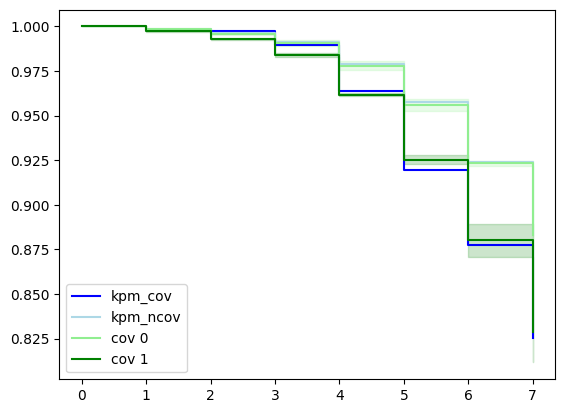

In [48]:
# transform to survival
# x_mat2 = np.vstack([np.array(x_mat), np.array(x_mat)])
bart_sv_fx = ssf.get_sv_fx(pp2, x_sk2)

cov_mask2 = x_sk2[:,0]==1
sv_cov = np.mean(bart_sv_fx[cov_mask2],0)
sv_ncov = np.mean(bart_sv_fx[~cov_mask2],0)
sv_cov = np.hstack([val_fill, sv_cov])
sv_ncov = np.hstack([val_fill, sv_ncov])
bart_sv_val = [sv_ncov, sv_cov]

bart_sv_t = np.unique(b_tr_t)
bart_sv_t = np.hstack([t_fill, bart_sv_t])

sv_cov_ci = np.quantile(bart_sv_fx[cov_mask2], [0.025,0.975], 0)
sv_ncov_ci = np.quantile(bart_sv_fx[~cov_mask2], [0.025,0.975], 0)

sv_cov_ci = np.hstack([[val_fill,val_fill], sv_cov_ci])
sv_ncov_ci = np.hstack([[val_fill,val_fill], sv_ncov_ci])



plt.step(kpm_cadj[0], kpm_cadj[1], color="blue", label="kpm_cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], color = "lightblue", label = "kpm_ncov", where="post")
# plt.plot(T, sv_unique[0], color= "lightblue", label="true 0")
# plt.plot(T, sv_unique[1], color = "blue", label="true 1")

plt.step(bart_sv_t, bart_sv_val[0], color = "lightgreen", label="cov 0", where="post")
plt.step(bart_sv_t, bart_sv_val[1], color = "green", label="cov 1", where="post")
plt.fill_between(bart_sv_t, sv_cov_ci[0], 
    sv_cov_ci[1],
    color = "green", alpha=0.2, step="post")
plt.fill_between(bart_sv_t, sv_ncov_ci[0], 
    sv_ncov_ci[1],
    color = "lightgreen", alpha=0.2, step="post")



plt.legend()

Partial Dependency plot displaying the effect of the primary variable on survival

In [71]:
# evaluate hazard rate
# get the dimension
shp1, shp2, shp3 = pp2.posterior_predictive["mu"].values.shape
shp4 = x_sk2.shape[0]
shp5 = bart_sv_t[1:].shape[0]
hz2 = pp2.posterior_predictive["mu"].values.reshape(shp1*shp2, shp3).mean(axis=0).reshape(shp4,shp5)

#HR
hz_all = hz2[int(shp4/2):,]/hz2[:int(shp4/2),]
print(hz_all.mean(0))
print(np.quantile(hz_all, [0.025, 0.975], axis=0))
# /hz2[:shp4/2,:]

[1.77126732 1.76458064 1.77507314 1.75978812 1.67424268 1.43275344
 1.34718721]
[[1.55604393 1.5593159  1.58369696 1.60686503 1.54235262 1.33891838
  1.26416618]
 [1.98705459 1.96922051 1.96614445 1.91216031 1.80536705 1.52562091
  1.42935615]]


Because there are more cases occuring earlier in the cov gorup rather than the non cov we see an elevated HR earlier on. As the cases begin to level out we should see the avg HR approximate the true HR with a larger sample or with a longer time frame

# COX

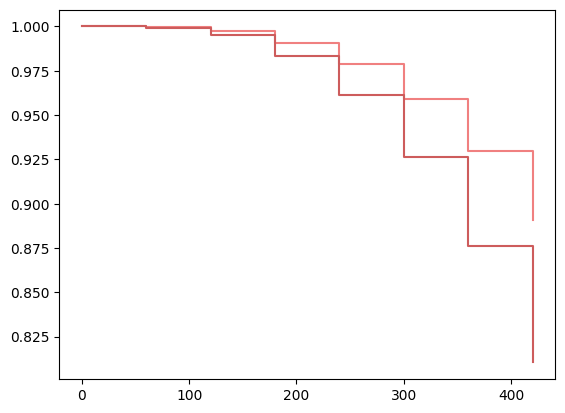

In [94]:
# Expected survival
# tmask = np.ceil(T/30) < 7
# error in t_adj, need to fix
tmask = np.arange(0,TT_ADJ+11,TT_SCALE)

sv_cv_tr = sv_mat[:,tmask][cov_mask,:].mean(0)
sv_ncv_tr = sv_mat[:,tmask][~cov_mask,:].mean(0)

# sv_mat[cov_mask]
plt.step(tmask, sv_ncv_tr, color = "lightcoral", where="post")
plt.step(tmask, sv_cv_tr, color = "indianred", where="post")

In [95]:
# tmask
np.arange(0,TT_ADJ+11,TT_SCALE)

(8,)

[1.54036842 1.10335374 1.08638004 1.0670502 ]


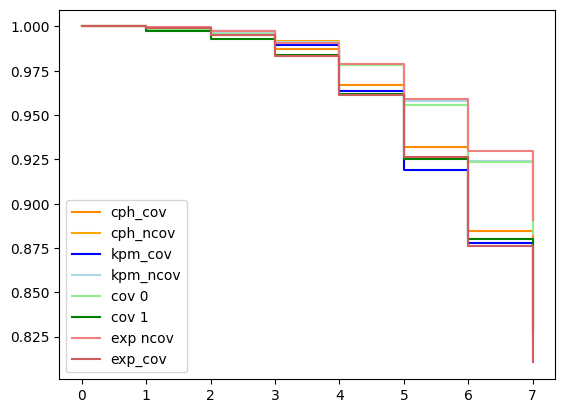

In [97]:
# check cph
cph = sks.linear_model.CoxPHSurvivalAnalysis().fit(x_sk, y_sk180)
print(np.exp(cph.coef_))

cph_sv = cph.predict_survival_function(x_sk)
cph_sv = np.array([fx(fx.x) for fx in cph_sv])


cph_sv_c = np.hstack([val_fill,np.mean(cph_sv[cov_mask,:],0)])
cph_sv_nc = np.hstack([val_fill, np.mean(cph_sv[~cov_mask,:],0)])

plt.step(bart_sv_t, cph_sv_c, color="darkorange", label="cph_cov", where="post")
plt.step(bart_sv_t, cph_sv_nc, color="orange", label="cph_ncov", where="post")
plt.step(kpm_cadj[0], kpm_cadj[1], color="blue", label="kpm_cov", where="post")
plt.step(kpm_ncadj[0], kpm_ncadj[1], color = "lightblue", label = "kpm_ncov", where="post")
# plt.plot(T, sv_unique[0], color= "lightblue", label="true 0")
# plt.plot(T, sv_unique[1], color = "blue", label="true 1")

plt.step(bart_sv_t, bart_sv_val[0], color = "lightgreen", label="cov 0", where="post")
plt.step(bart_sv_t, bart_sv_val[1], color = "green", label="cov 1", where="post")
plt.step(tmask/TT_SCALE, sv_ncv_tr, color = "lightcoral", label="exp ncov", where="post")
plt.step(tmask/TT_SCALE, sv_cv_tr, color = "indianred", label="exp_cov", where="post")
plt.legend()
# plt.xlim(0,7)
# bart_sv_t
# cph_sv_nc

# C-INDEX

In [98]:
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

In [107]:
# set up hazards to use
shp1,shp2,shp3 = pp.posterior_predictive["mu"].values.shape
shp4 = x_sk.shape[0]
shp5 = np.unique(b_tr_t).shape[0]

hz1 = pp.posterior_predictive["mu"].values.reshape(shp1*shp2, shp3).mean(axis=0).reshape(shp4,shp5)
chz1 = np.cumsum(hz1, axis=1)

cph_chz = cph.predict_cumulative_hazard_function(x_sk)
cph_chz = np.array([fn(fn.x) for fn in cph_chz])


In [108]:
# compare hazards 
print(chz2[:2,:])
print(cph_chz[:2,:])

[[0.00118944 0.0032256  0.00758309 0.01980916 0.04172806 0.07822929
  0.12535931]
 [0.00121662 0.0033034  0.00777606 0.02027082 0.04258103 0.07960146
  0.12730632]]
[[0.00138267 0.00484309 0.01247437 0.03340866 0.06960499 0.12144196
  0.18670435]
 [0.00080247 0.00281083 0.00723986 0.01938968 0.04039726 0.07048233
  0.10835923]]


In [110]:
for i in np.arange(hz1.shape[1]):
    ci = concordance_index_censored(y_sk180["Status"], y_sk180["Survival_in_days"], hz1[:,i])
    print(f"bart cindex: {ci}")

for i in np.arange(cph_chz.shape[1]):
    ci = concordance_index_censored(y_sk180["Status"], y_sk180["Survival_in_days"], cph_chz[:,i])
    print(f"cph cindex: {ci}")


bart cindex: (0.6094255371528986, 287133, 184013, 42, 149984)
bart cindex: (0.6119319677071572, 288320, 182838, 30, 149984)
bart cindex: (0.6165553876584293, 290505, 180666, 17, 149984)
bart cindex: (0.6206503561211236, 292439, 178741, 8, 149984)
bart cindex: (0.6213729976145402, 292781, 178402, 5, 149984)
bart cindex: (0.631267137533214, 297444, 173741, 3, 149984)
bart cindex: (0.6309487932629864, 297293, 173890, 5, 149984)
cph cindex: (0.56500377768534, 266217, 204959, 12, 149984)
cph cindex: (0.5650027165377726, 266218, 204961, 9, 149984)
cph cindex: (0.5650005942426377, 266219, 204964, 5, 149984)
cph cindex: (0.5649974107999355, 266219, 204967, 2, 149984)
cph cindex: (0.5649974107999355, 266219, 204967, 2, 149984)
cph cindex: (0.5649974107999355, 266219, 204967, 2, 149984)
cph cindex: (0.5649974107999355, 266219, 204967, 2, 149984)


Based on c-index we can see that the bart model performs significantly better at this smaller time frame than the cox model

# time-auc

In [176]:
# adjust y_sk180 to allow ipcw
y_sk180tmp = y_sk180.copy()
idx_cens = np.where(y_sk180tmp["Survival_in_days"] == shp5)[0][:1]
y_sk180tmp["Survival_in_days"][idx_cens] = 8
y_sk180tmp["Status"][idx_cens] = True


In [186]:
# CDA
cph_cda = cumulative_dynamic_auc(
    survival_train=y_sk180tmp, 
    survival_test=y_sk180tmp, 
    estimate=cph_chz[:,1:7], 
    times=bart_sv_t[1:7]
)

brt_cda = cumulative_dynamic_auc(
    survival_train=y_sk180tmp, 
    survival_test=y_sk180tmp, 
    estimate=hz1[:,1:7], 
    times=bart_sv_t[1:7]
)

print(brt_cda)
print(cph_cda)

(array([0.45995996, 0.60268081, 0.6490638 , 0.64610015, 0.61875727,
       0.6363838 ]), 0.6305641236709417)
(array([0.74324324, 0.53214823, 0.57946519, 0.63162782, 0.58992078,
       0.55783028]), 0.5833064037196501)


In [151]:

# y_sk 
# prob1
# r
p_cda = cumulative_dynamic_auc(survival_train=y_sk, survival_test=y_sk, estimate=prob1[:,1:], times=bart_sv_t[1:11])
r_cda = cumulative_dynamic_auc(survival_train=y_sk, survival_test=y_sk, estimate=rb_prob_val[:,:10], times=bart_sv_t[1:11])
# bart_sv_t[1:12]

# Integrated Brier score

In [190]:
bart_sv_brier = ssf.get_sv_fx(pp, x_sk)

In [219]:
bart_ibs = integrated_brier_score(y_sk180, y_sk180, bart_sv_brier[:, 1:7], bart_sv_t[1:7])
cph_ibs = integrated_brier_score(y_sk180, y_sk180, cph_sv[:, 1:7], bart_sv_t[1:7])

print(bart_ibs)
print(cph_ibs)

0.024982066205756104
0.024950324664630364


Brier score performs well on the training data

# Test

In [253]:
def test_sample():
    sv_mat, hz_mat, x_mat, lmbda, a, cens, t_event, status, T = ssf.sim_surv2(
                    N=N, 
                    x_vars=X_VARS,
                    VAR_CLASS= VAR_CLASS,
                    VAR_PROB = VAR_PROB,
                    a = ALPHA,
                    lambda_f = LAMBDA,
                    cens_scale=CENS_SCALE,
                    cens_ind = CENS_IND,
                    err_ind = False)


    # Get information of X vars
    x_out, x_idx, x_cnt = ssf.get_x_info(x_mat)
    # calculate censored components
    event_calc, cens_calc = ssf.get_status_perc(status) 
    # Get the t mean and max
    t_mean, t_max = ssf.get_event_time_metric(t_event)
    # Get the training matrix
    train = ssf.get_train_matrix(x_mat, t_event, status)

    # plots moved to kpm by group
    title = "actual_survival"
    ssf.plot_sv(x_mat, sv_mat, T, title=title, save = False, show=True, dir=OUTPUTS)

    print(f"cens_calc: {cens_calc} \
        \nt_mean: {t_mean} \
        \nt_max: {t_max}")


    # set the eos censoring
    TT_ADJ = 410
    TT_SCALE = 60
    tt_180 = t_event.copy()
    y_stat = t_event.copy()
    tt_180[tt_180 >= TT_ADJ] = TT_ADJ
    tt_180_sc6 = np.ceil(tt_180/TT_SCALE)

    y_stat[tt_180 >= TT_ADJ] = 0
    y_stat[tt_180 < TT_ADJ] = 1

    print(f"{TT_ADJ} day cases")
    print(f"covid events {y_stat[cov_mask].sum()}")
    print(f"covid count {y_stat[cov_mask].shape[0]}")
    print(f"ncov events {y_stat[~cov_mask].sum()}")
    print(f"ncov count {y_stat[~cov_mask].shape[0]}")


    # KPM for the time adjusted

    # y_sk = ssf.get_y_sklearn(status, t_event)
    y_sk180 = ssf.get_y_sklearn(y_stat, tt_180_sc6)
    x_sk = train.iloc[:,2:]


    # tranform data long-form
    b_tr_t, b_tr_delta, b_tr_x = ssf.surv_pre_train2(x_sk, y_sk180)
    # b_te_t, b_te_x = surv_pre_test(x_sk, y_sk)
    # b_te_x = ssf.get_bart_test(x_out, np.unique(b_tr_t))
    b_te_x = ssf.get_bart_test(x_sk, np.unique(b_tr_t))
    off = sp.norm.ppf(np.mean(b_tr_delta))

    with bart:
        pm.set_data({"x":pd.DataFrame(b_te_x)}, coords= {"obs":np.arange(0,b_te_x.shape[0],1)})
        pp = pm.sample_posterior_predictive(bdata, var_names = ["y_pred", "f", "z", "mu"])


    # fill times
    t_min = np.unique(b_tr_t).min()
    t_fill = np.arange(t_min)
    val_fill = np.ones(t_fill.shape)

    # transform to survival
    bart_sv_fx = ssf.get_sv_fx(pp, x_sk)
    sv_cov = np.mean(bart_sv_fx[cov_mask],0)
    sv_ncov = np.mean(bart_sv_fx[~cov_mask],0)
    sv_cov = np.hstack([val_fill, sv_cov])
    sv_ncov = np.hstack([val_fill, sv_ncov])
    bart_sv_val = [sv_ncov, sv_cov]

    bart_sv_t = np.unique(b_tr_t)
    bart_sv_t = np.hstack([t_fill, bart_sv_t])

    # cox 
    cph = sks.linear_model.CoxPHSurvivalAnalysis().fit(x_sk, y_sk180)
    print(np.exp(cph.coef_))

    cph_sv = cph.predict_survival_function(x_sk)
    cph_hz = cph.predict_cumulative_hazard_function(x_sk)
    cph_sv = np.array([fx(fx.x) for fx in cph_sv])

    # set up hazards to use
    shp1,shp2,shp3 = pp.posterior_predictive["mu"].values.shape
    shp4 = x_sk.shape[0]
    shp5 = np.unique(b_tr_t).shape[0]

    hz1 = pp.posterior_predictive["mu"].values.reshape(shp1*shp2, shp3).mean(axis=0).reshape(shp4,shp5)
    chz1 = np.cumsum(hz1, axis=1)

    return y_sk180, bart_sv_fx, hz1, cph_sv, cph_hz

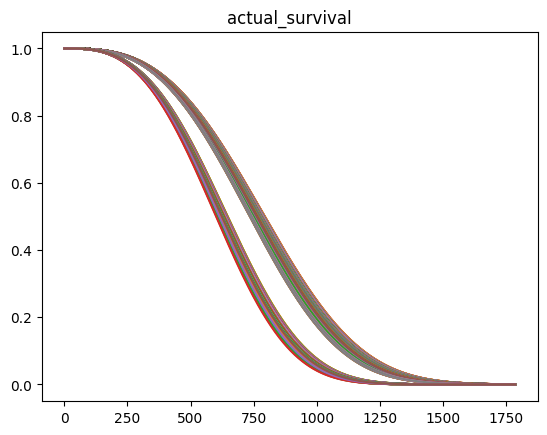

cens_calc: 0.0         
t_mean: 745.4705         
t_max: 1786.0
410 day cases
covid events 42.0
covid count 384
ncov events 183.0
ncov count 1616


Sampling: [f, y_pred]


[1.73742474 1.04068624 1.04601809 1.15438989]


In [254]:
test_y, test_b_sv_fx, test_b_hz, test_cph_sv, test_cph_hz = test_sample()

In [255]:
test_t = np.unique(test_y["Survival_in_days"])
test_t

array([1., 2., 3., 4., 5., 6., 7.])

In [256]:
test_bibs = integrated_brier_score(y_sk180, test_y, test_b_sv_fx[:, :-1], test_t[:-1])
test_cibs = integrated_brier_score(y_sk180, test_y, test_cph_sv[:, :-1], test_t[:-1])
print(test_bibs)
print(test_cibs)

0.02352119652569955
0.023502489064021227


In [258]:
cumulative_dynamic_auc(survival_train=y_sk180tmp, survival_test=test_y, estimate=-np.log(test_b_hz[:,:-1]), times=test_t[:-1])
# cumulative_dynamic_auc(survival_train=y_sk180tmp, survival_test=test_y, estimate=-np.log(test_cph_hz[:,:-1]), times=test_t[:-1])

(array([0.16008004, 0.48779672, 0.46924732, 0.49897886, 0.47212052,
        0.46497235]),
 0.4732101503150828)

Skip cumulative dynamic auc since the censoring distribution causes problems.